# Prediction Results

In [4]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [ ]:
def summarize_best_results_by_index(results, metadata, metric="r2", stage="prediction", top_n=1):

    # Filter for prediction stage based on metric
    prediction_results = results[(results["stage"] == stage) & (results["metric"] == metric)& (results["model"]!="Linear")]
    #prediction_results = results[(results["stage"] == stage) & (results["metric"] == metric)]


    # Find the top N best values per index (maximize for r2 and cv_r2, minimize for mape)
    best_results = prediction_results.set_index(["model", "season", "id_data"])[["HWN", "HWF", "HWD", "HWM", "HWA", "Average"]].stack().reset_index()
    best_results.columns = ["model", "season", "id_data", "index", "best_value"]
    
    if metric in ["r2", "cv_r2"]:
        best_results = best_results.groupby("index").apply(lambda x: x.nlargest(top_n, "best_value")).reset_index(drop=True)
    else:  # metric == "mape"
        best_results = best_results.groupby("index").apply(lambda x: x.nsmallest(top_n, "best_value")).reset_index(drop=True)

    # Get corresponding training values
    if metric in ["r2", "mape"]:
        training_results = results[(results["stage"] == "training") & (results["metric"] == metric) & results["id_data"].isin(best_results["id_data"])]
        training_results = training_results.set_index(["model", "season", "id_data"])[["HWN", "HWF", "HWD", "HWM", "HWA", "Average"]].stack().reset_index()
        training_results.columns = ["model", "season", "id_data", "index", "training_value"]

        # Merge best prediction results with training values
        summary = best_results.merge(training_results, on=["model", "season", "id_data", "index"], how="left")

    else:
        summary = best_results
    # Merge with metadata
    summary = summary.merge(metadata, on=["id_data","season"], how="left")

    # Save summary
    #summary.to_csv(f"summary_best_{metric}_results.csv", index=False)

    return summary

def plot_best_results_per_season(df, metric, title):
    seasons = sorted(df["season"].unique())
    
    fig, axes = plt.subplots(3, 5, figsize=(18, 10))  # Adjust layout
    axes = axes.flatten()

    # Get unique models for the legend
    unique_models = df["model"].unique()
    palette = sns.color_palette("tab10", len(unique_models))  # Assign colors
    model_colors = dict(zip(unique_models, palette))  # Map models to colors

    for i, season in enumerate(seasons):
        ax = axes[i]
        season_data = df[df["season"] == season]

        sns.barplot(
            data=season_data, 
            x="index", y="best_value", hue="model", ax=ax, 
            dodge=True, palette=model_colors
        )
        if season==0:
            ax.set_title(f"Yearly")
        else:
            ax.set_title(f"Season {season}")
        ax.set_xlabel("Index")
        ax.set_ylabel(metric)
        ax.legend().remove()  # Remove subplot legends
        if "MAPE" in metric:
            ax.set_ylim(bottom=0, top=0.5)
        else:
            ax.set_ylim(bottom=0, top=1)
    
    # Create a single global legend
    handles = [plt.Rectangle((0,0),1,1, color=model_colors[model]) for model in unique_models]
    fig.legend(handles, unique_models, title="Model", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=len(unique_models))

    # Adjust layout
    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.90)  # Space for the suptitle and legend
    plt.show()

def plot_average_best_results(df, metric, title):
    # Compute the average best result per index across all seasons
    df1 = df[df["season"]!=0]
    avg_best_results = df1.groupby("index")["best_value"].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 6))
    sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")

    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel(f"Average {metric} (Best per Season)")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.show()

In [25]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

def plot_grid_count(df):
    # Create a figure and axis
    grid_counts = df['box'].value_counts()
    fig = plt.figure(figsize=(20, 16))
    ax = fig.add_subplot(2, 1, 1, projection=ccrs.PlateCarree())
    ax2 = fig.add_subplot(2, 1, 2, projection=ccrs.PlateCarree())

    # Set map extent
    ax.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

    # Add land and coastlines
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)

    # Plot the boxes and their counts
    for grid, count in grid_counts.items():
        if grid in boxes1.values():
            min_lon, max_lon, min_lat, max_lat = grid
            
            ax.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                    [min_lat, min_lat, max_lat, max_lat, min_lat],
                    color='black', linewidth=1, transform=ccrs.PlateCarree())
            ax.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                    str(count),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ccrs.PlateCarree(), color="r")
            

    ax2.set_extent([120, 290, -60, 60], crs=ccrs.PlateCarree())

    # Add land and coastlines
    ax2.add_feature(cfeature.LAND)
    ax2.add_feature(cfeature.COASTLINE)

    # Plot the boxes and their counts
    for grid, count in grid_counts.items():
        if grid in boxes2.values():
            min_lon, max_lon, min_lat, max_lat = grid
            
            ax2.plot([min_lon, max_lon, max_lon, min_lon, min_lon],
                    [min_lat, min_lat, max_lat, max_lat, min_lat],
                    color='black', linewidth=1, transform=ccrs.PlateCarree())
            ax2.text((min_lon + max_lon) / 2, (min_lat + max_lat) / 2,
                    str(count),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ccrs.PlateCarree(), color="r")

    plt.show()

In [7]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())


folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

from PredictorsDrivers import (
    PCAPredictors
)

c:\Users\marti\Desktop\data\hw_extra


## California

In [26]:
region = "california"
FREQUENCY= "2monthly"
metadata_sst = pd.read_csv(f"data/new_features/{region}/metadata.csv")
metadata_sst["var_temp"] = "sst"
metadata_t2m = pd.read_csv(f"data/new_features_t2m/{region}/metadata.csv")
metadata_t2m["var_temp"] = "t2m"
metadata = pd.concat((metadata_sst,metadata_t2m))
metadata.rename(columns={"id":"id_data"}, inplace=True)
metadata

,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,var_temp
0,0711afc4,predictor_0711afc4.parquet,0,5,NaN,1,yearly,0,ps,sst
1,193414ce,predictor_193414ce.parquet,0,10,NaN,1,yearly,0,ps,sst
2,4e69fe46,predictor_4e69fe46.parquet,0,15,NaN,1,yearly,0,ps,sst
3,6af23f2d,predictor_6af23f2d.parquet,0,20,NaN,1,yearly,0,ps,sst
4,3405d1e5,predictor_3405d1e5.parquet,0,30,NaN,1,yearly,0,ps,sst
...,...,...,...,...,...,...,...,...,...,...
775,6259a7a0,predictor_6259a7a0_8.parquet,0,30,0.15,3,2monthly,8,ps,t2m
776,6259a7a0,predictor_6259a7a0_9.parquet,0,30,0.15,3,2monthly,9,ps,t2m
777,6259a7a0,predictor_6259a7a0_10.parquet,0,30,0.15,3,2monthly,10,ps,t2m
778,6259a7a0,predictor_6259a7a0_11.parquet,0,30,0.15,3,2monthly,11,ps,t2m


In [40]:
results = pd.read_csv(f"data/{region}_results/results.csv")
results

,model,season,metric,stage,HWN,HWF,HWD,HWM,HWA,Average,id_data
0,Linear,0,r2,prediction,-2.989712,-2.060381,-0.996922,-0.538515,-0.994325,-1.515971,1e8f838e
1,RF5,0,r2,prediction,-4.529737,-3.891622,-2.262463,-0.713237,-2.062737,-2.691959,1e8f838e
2,RF10,0,r2,prediction,-3.574376,-2.730330,-2.091281,-1.172627,-1.243617,-2.162446,1e8f838e
3,SVR-rbf,0,r2,prediction,-3.488333,-2.697044,-1.681060,-0.399871,-0.783319,-1.809925,1e8f838e
4,XGB10,0,r2,prediction,-4.613917,-3.892783,-3.121469,-1.058132,-1.273952,-2.792050,1e8f838e
...,...,...,...,...,...,...,...,...,...,...,...
54595,RF10,12,cv_r2,CV,-2.367464,-2.057777,-0.150084,0.306334,-0.162763,-0.886351,f579dc90
54596,SVR-rbf,12,cv_r2,CV,-2.234007,-1.343167,0.429356,0.440590,-0.255609,-0.592567,f579dc90
54597,XGB10,12,cv_r2,CV,-2.067115,-1.580559,0.346948,0.107145,-0.578878,-0.754492,f579dc90
54598,XGB15,12,cv_r2,CV,-2.635809,-2.252827,0.219982,0.162251,-0.528323,-1.006945,f579dc90


In [41]:
# Example usage
summary_r2 = summarize_best_results_by_index(results, metadata, metric="r2", top_n=5, stage="prediction")
summary_mape = summarize_best_results_by_index(results, metadata, metric="mape", top_n=5, stage="prediction")
summary_cv_r2 = summarize_best_results_by_index(results, metadata, metric="cv_r2", top_n=5, stage="CV")


In [42]:
summary_cv_r2

,model,season,id_data,index,best_value,filename,boxes,top_n,var_thresh,modes,frequency,methods,var_temp
0,GPR,7,11c32872,Average,0.341702,predictor_11c32872_7.parquet,0,30,0.10,3,2monthly,ps,t2m
1,GPR,7,04c44aa0,Average,0.320074,predictor_04c44aa0_7.parquet,0,30,NaN,3,2monthly,ps,t2m
2,GPR,7,f95a0de0,Average,0.320074,predictor_f95a0de0_7.parquet,0,30,0.05,3,2monthly,ps,t2m
3,GPR,7,457f46bf,Average,0.317223,predictor_457f46bf_7.parquet,0,20,0.10,2,2monthly,ps,t2m
4,GPR,7,2fe107ef,Average,0.312612,predictor_2fe107ef_7.parquet,0,20,NaN,2,2monthly,ps,t2m
5,RF10,9,76c7ef4c,HWA,0.421942,predictor_76c7ef4c_9.parquet,0,5,0.15,2,2monthly,ps,t2m
6,RF5,9,76c7ef4c,HWA,0.418042,predictor_76c7ef4c_9.parquet,0,5,0.15,2,2monthly,ps,t2m
7,XGB15,6,dd210fee,HWA,0.361485,predictor_dd210fee_6.parquet,0,5,NaN,3,2monthly,ps,t2m
8,XGB15,6,c1dd5cf4,HWA,0.361485,predictor_c1dd5cf4_6.parquet,0,5,0.05,3,2monthly,ps,t2m
9,RF5,11,8cd02fc5,HWA,0.356546,predictor_8cd02fc5_11.parquet,0,10,NaN,3,2monthly,ps,t2m


Now we repite for each season

In [29]:
cv_r2_seasons = {}
r2_seasons = {}
mape_seasons = {}
for i in range(13):
    results_season = results[results["season"]==i]
    cv_r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="cv_r2",stage="CV" , top_n=2)
    r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="r2",stage="prediction", top_n=2)
    mape_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="mape",stage="prediction", top_n=2)

cv_r2_seasons = pd.concat(list(cv_r2_seasons.values()))
r2_seasons = pd.concat(list(r2_seasons.values()))
mape_seasons = pd.concat(list(mape_seasons.values()))
print()
r2_seasons[["model","season", "index", "best_value", "training_value", "top_n", "var_thresh", "var_temp"]].to_csv("r2_per_season.csv", index=False)
cv_r2_seasons[["model","season", "index", "best_value", "top_n", "var_thresh", "var_temp"]].to_csv("cv_r2_per_season.csv", index=False)

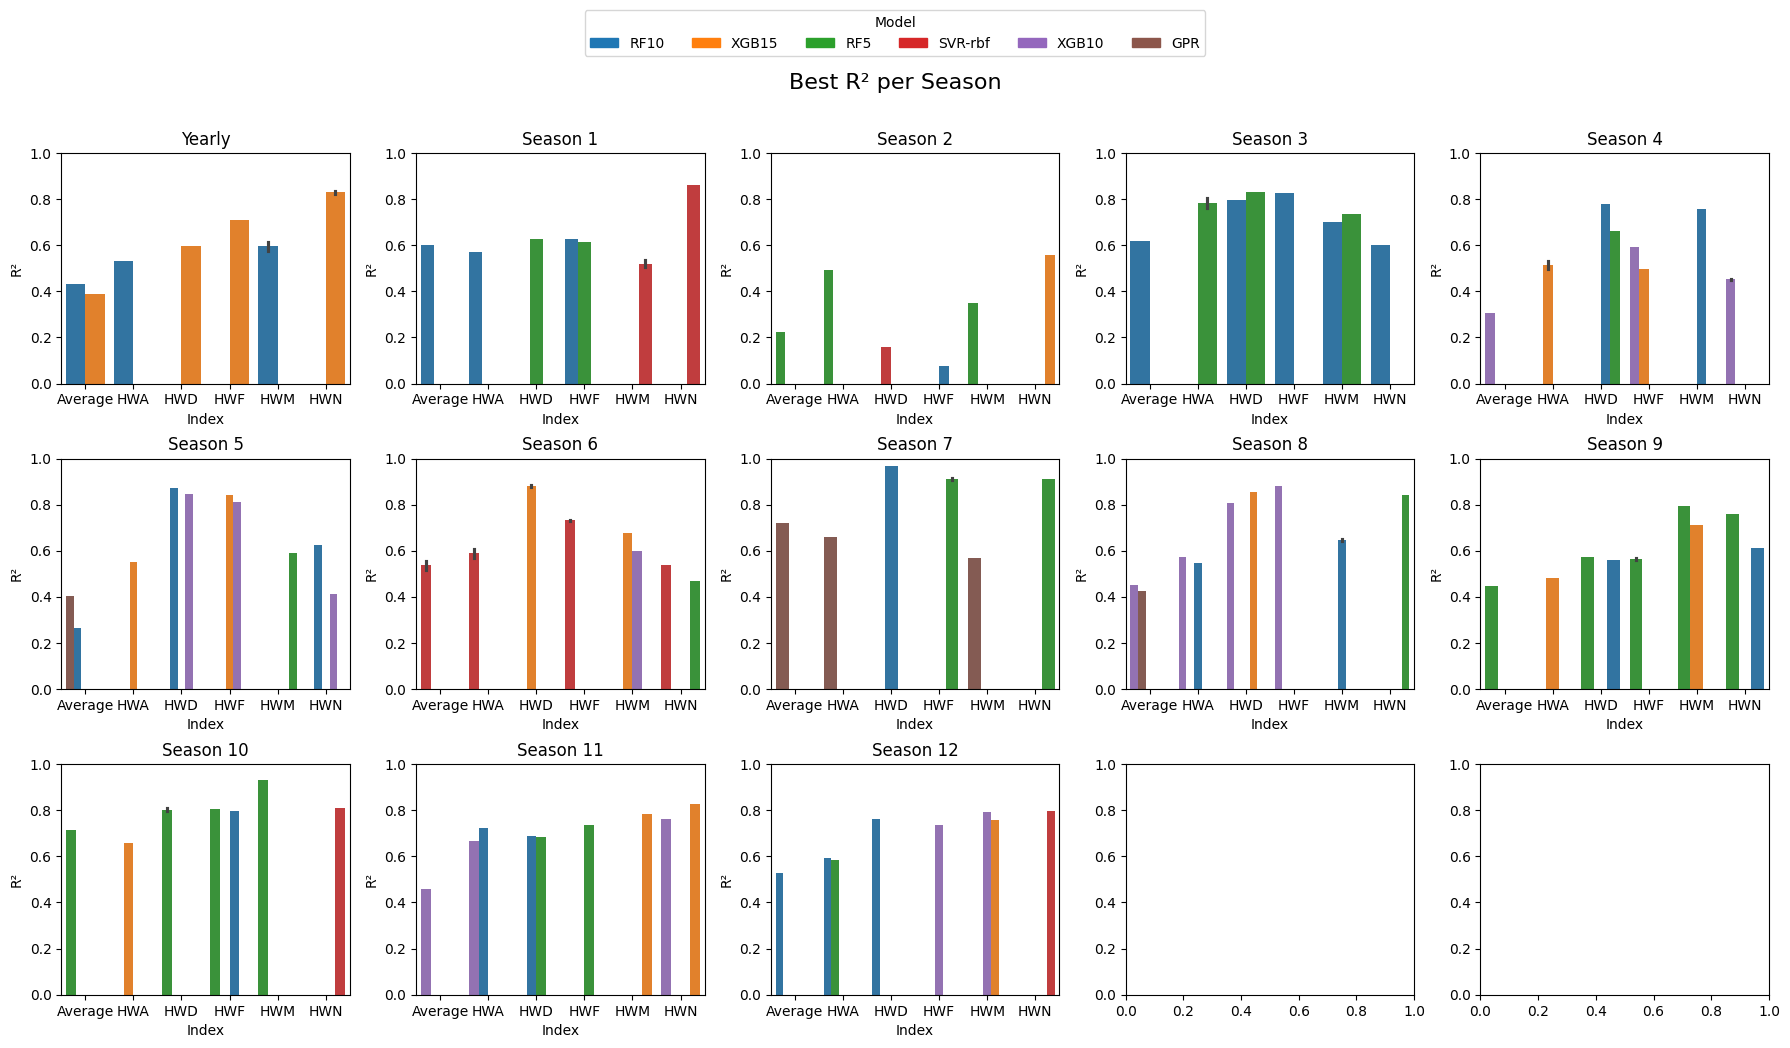

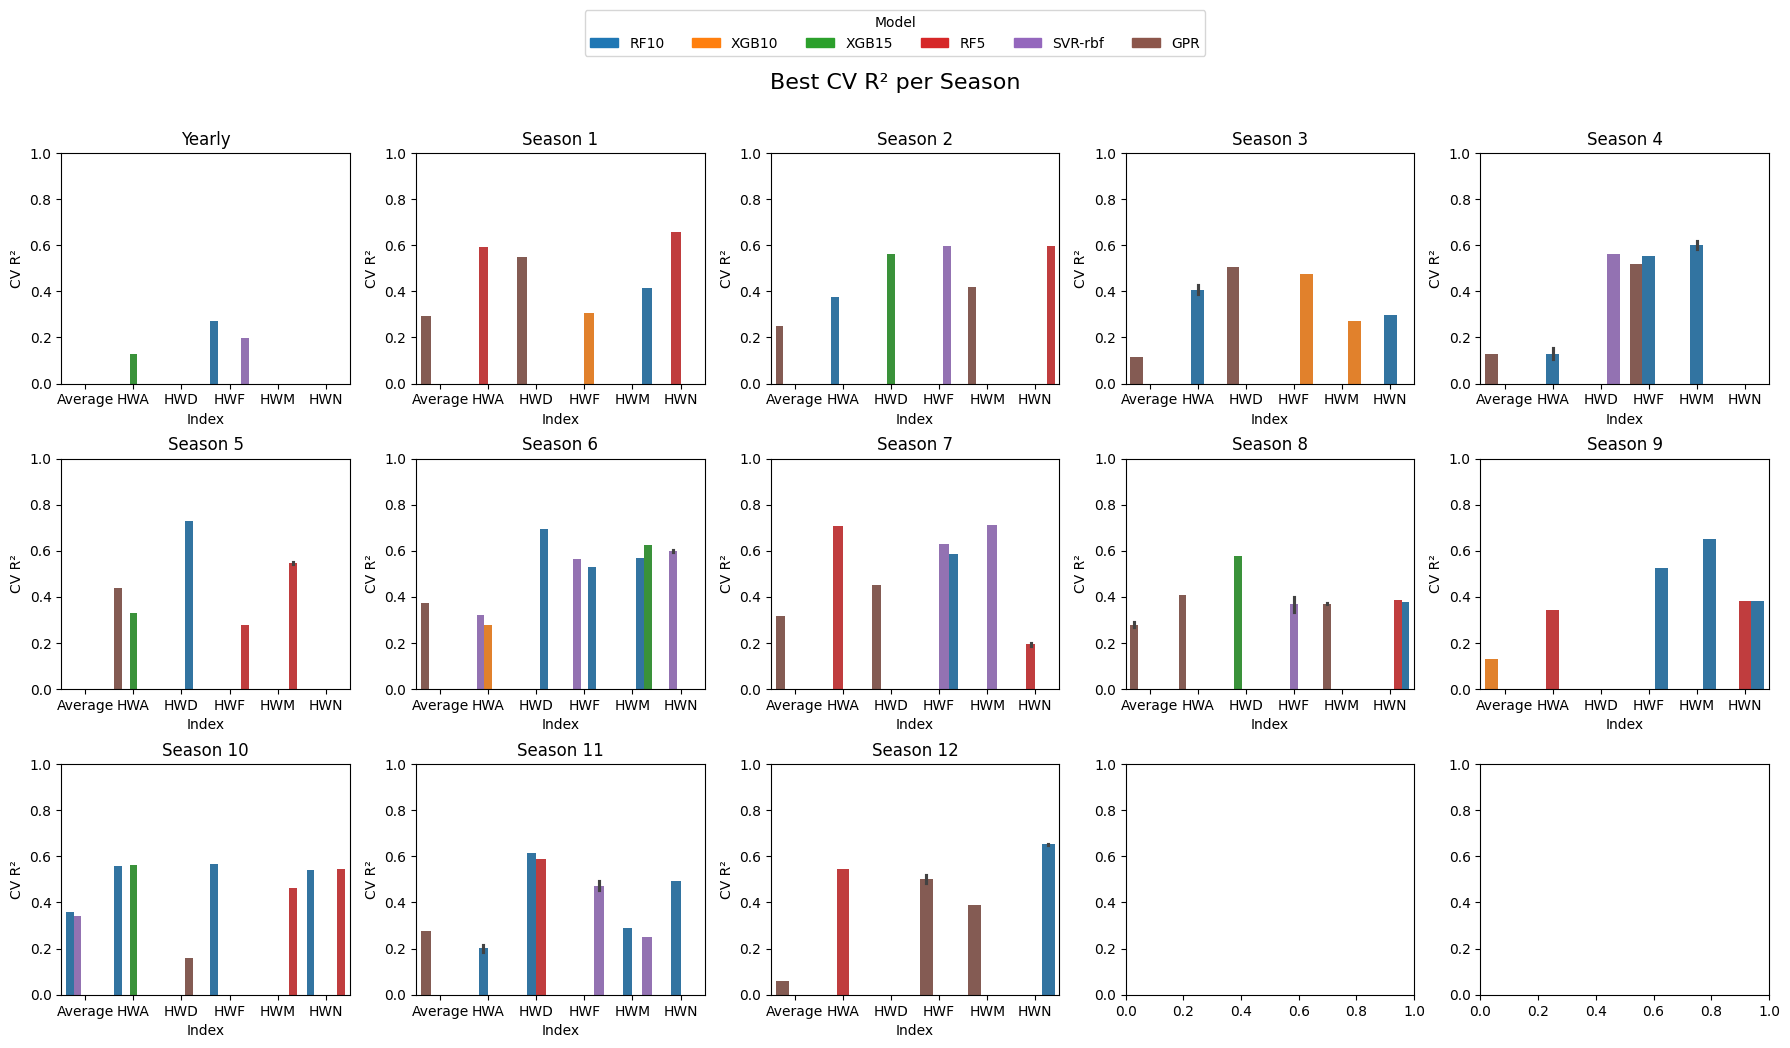

<Figure size 1800x1000 with 0 Axes>

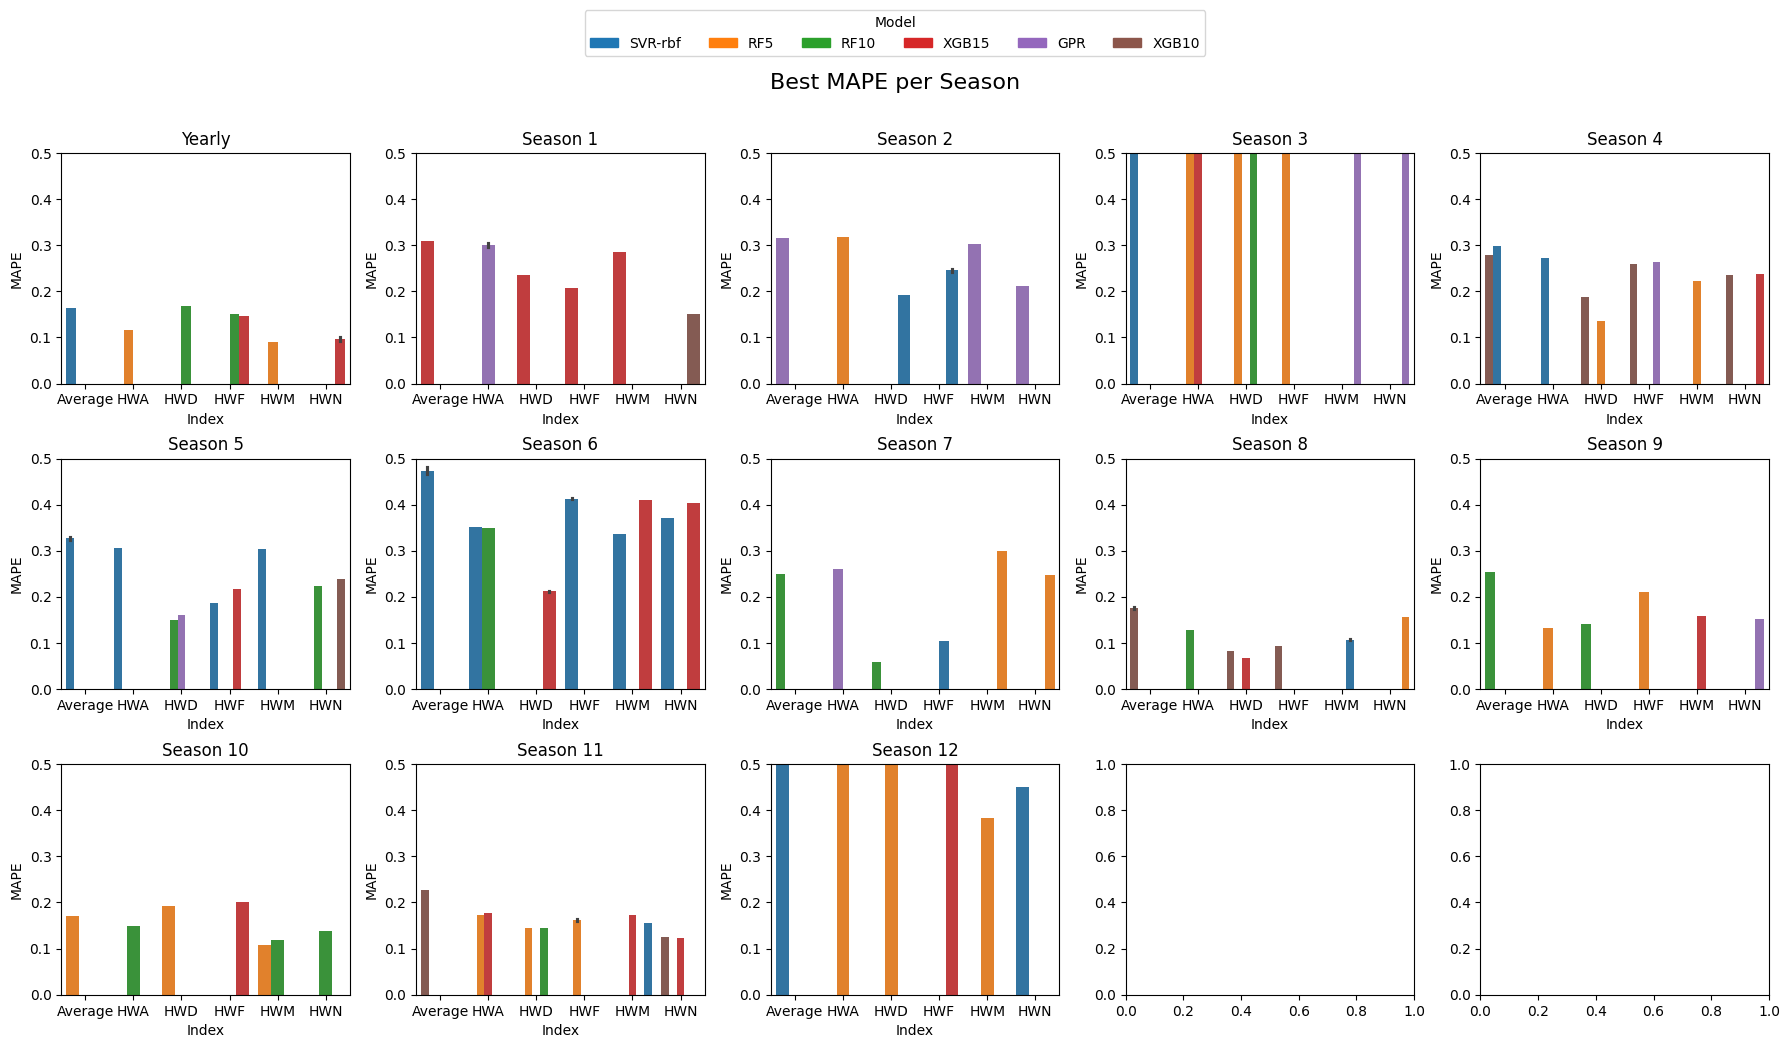

In [30]:
# Plot R2 results
plot_best_results_per_season(r2_seasons, "R²", "Best R² per Season")

# Plot CV R2 results
plot_best_results_per_season(cv_r2_seasons, "CV R²", "Best CV R² per Season")

# Plot MAPE results (invert y-axis since lower is better)
plt.figure(figsize=(18, 10))
plot_best_results_per_season(mape_seasons, "MAPE", "Best MAPE per Season")

C:\Users\marti\AppData\Local\Temp\ipykernel_3436\1172037756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


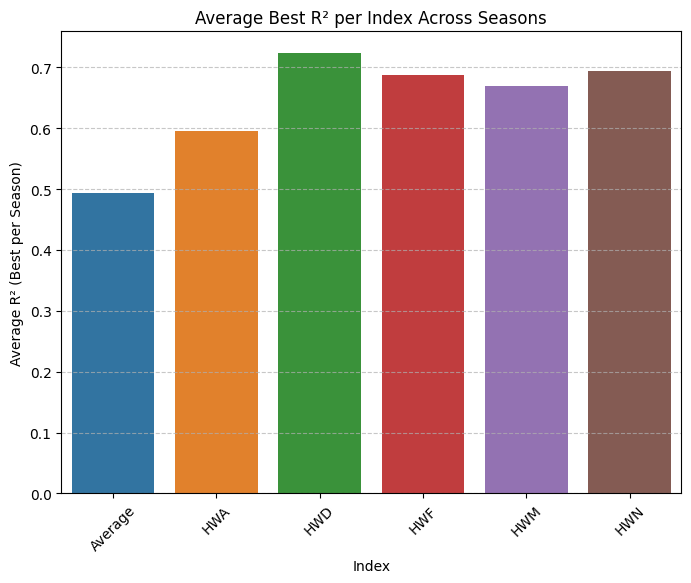

C:\Users\marti\AppData\Local\Temp\ipykernel_3436\1172037756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


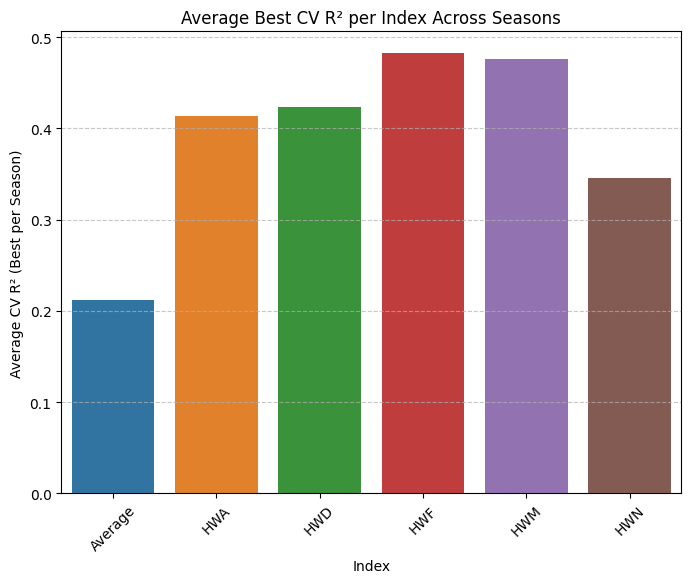

C:\Users\marti\AppData\Local\Temp\ipykernel_3436\1172037756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


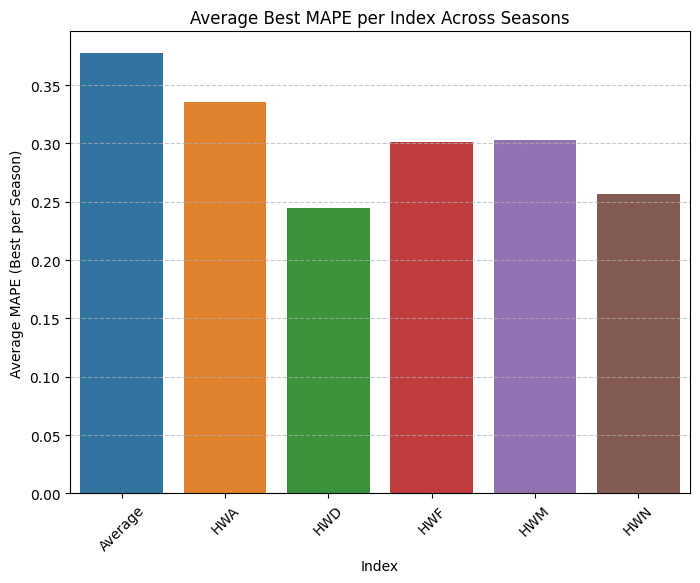

In [ ]:
# Example usage
plot_average_best_results(r2_seasons, "R²", "Average Best R² per Index Across Seasons")
plot_average_best_results(cv_r2_seasons, "CV R²", "Average Best CV R² per Index Across Seasons")
plot_average_best_results(mape_seasons, "MAPE", "Average Best MAPE per Index Across Seasons")

In [13]:
with open("pcas_1972.pkl", "rb") as inp:
    pcas_sst = pickle.load(inp)
interest_ids = cv_r2_seasons[(cv_r2_seasons["best_value"] >= 0.7)]
df1 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["var_temp"] == "t2m":
        continue
    else:
        temp = ""
        data_file = pd.read_parquet(f"data/new_features{temp}/california/predictor_{id}_{season}.parquet")
        pcas = list(data_file.columns[5:])
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_sst[id_pca].variables_dict.values())
            box = pcas_sst[id_pca].box
            mode = pcas[i][-1]
            df1.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_sst
display(df1)



,id_data,id_pca,mode,box,variables
0,dbbafbb7,387,2,"[205, 247.5, 0, 30]","[SST, V10]"
1,dbbafbb7,462,2,"[247.5, 290, 0, 30]","[SST, SP, TTR]"
2,dbbafbb7,484,2,"[247.5, 290, 0, 30]","[SST, SP, TTR, Z]"
3,dbbafbb7,447,1,"[247.5, 290, 0, 30]","[SST, SP]"
4,dbbafbb7,1222,2,"[205, 290, 0, 30]","[SST, TTR, U10]"
5,dbbafbb7,401,2,"[205, 247.5, 0, 30]","[SST, SP, V10]"
6,dbbafbb7,482,2,"[247.5, 290, 0, 30]","[SST, SP, TTR, U10]"
7,dbbafbb7,448,2,"[247.5, 290, 0, 30]","[SST, TTR]"
8,dbbafbb7,260,2,"[120, 162.5, 0, 30]","[SST, U10]"
9,dbbafbb7,441,1,"[247.5, 290, 0, 30]",[SST]


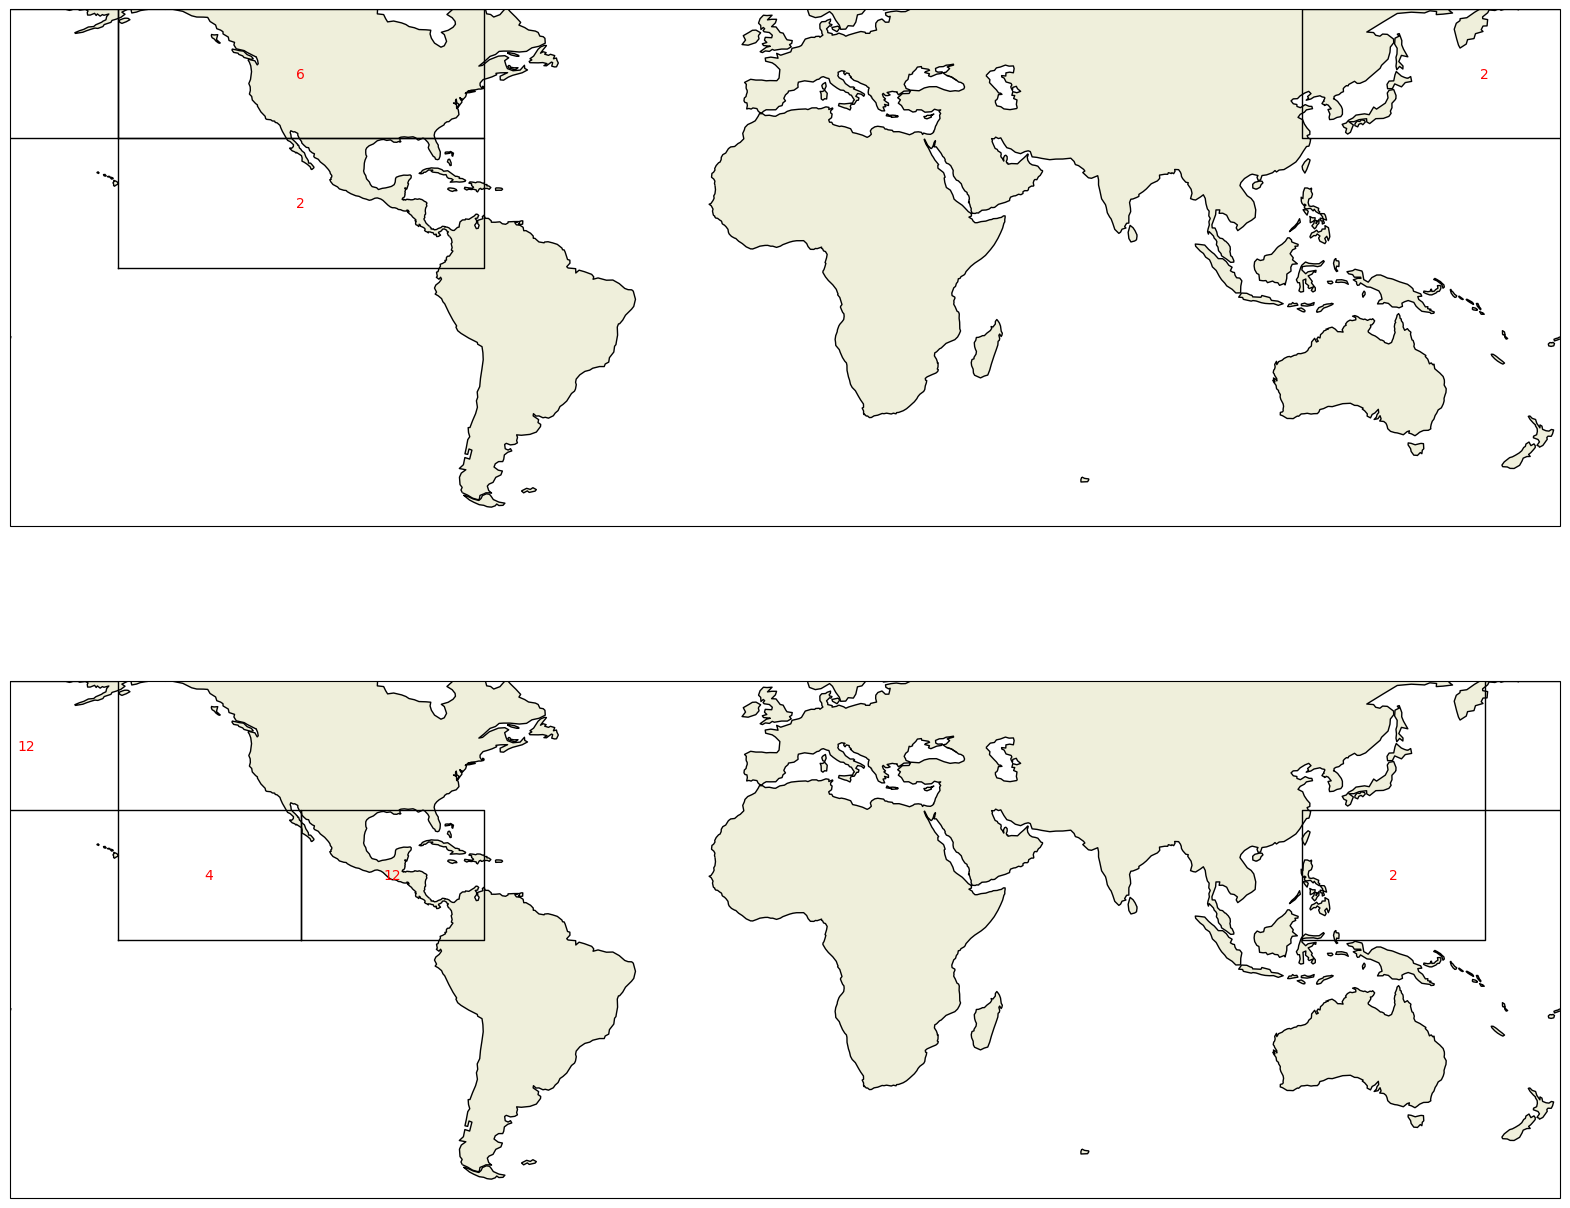

In [14]:
plot_grid_count(df1)

In [15]:
with open("pcas_t2m.pkl", "rb") as inp:
    pcas_t2m = pickle.load(inp)
df2 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["var_temp"] == "t2m":
        temp = "_t2m"
        with open("pcas_t2m.pkl", "rb") as inp:
            pcas_t2m = pickle.load(inp)
        data_file = pd.read_parquet(f"data/new_features{temp}/california/predictor_{id}_{season}.parquet")
        pcas = list(data_file.columns[5:])
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_t2m[id_pca].variables_dict.values())
            box = pcas_t2m[id_pca].box
            mode = pcas[i][-1]
            df2.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_t2m
display(df2)

,id_data,id_pca,mode,box,variables
0,63723b54,142,3,"[205, 247.5, 30, 60]","[U10, Z]"
1,63723b54,130,2,"[205, 247.5, 30, 60]",[Z]
2,63723b54,165,3,"[205, 247.5, 30, 60]","[U10, Z, T2M]"
3,63723b54,1027,2,"[120, 205, 30, 60]","[V10, T2M]"
4,63723b54,66,1,"[162.5, 205, 30, 60]",[V10]
5,63723b54,186,3,"[205, 247.5, 30, 60]","[SP, U10, V10, Z, T2M]"
6,63723b54,175,3,"[205, 247.5, 30, 60]","[SP, U10, Z, T2M]"
7,63723b54,85,2,"[162.5, 205, 30, 60]","[SP, TTR, V10]"
8,63723b54,174,3,"[205, 247.5, 30, 60]","[SP, U10, V10, T2M]"
9,63723b54,152,3,"[205, 247.5, 30, 60]","[SP, U10, Z]"


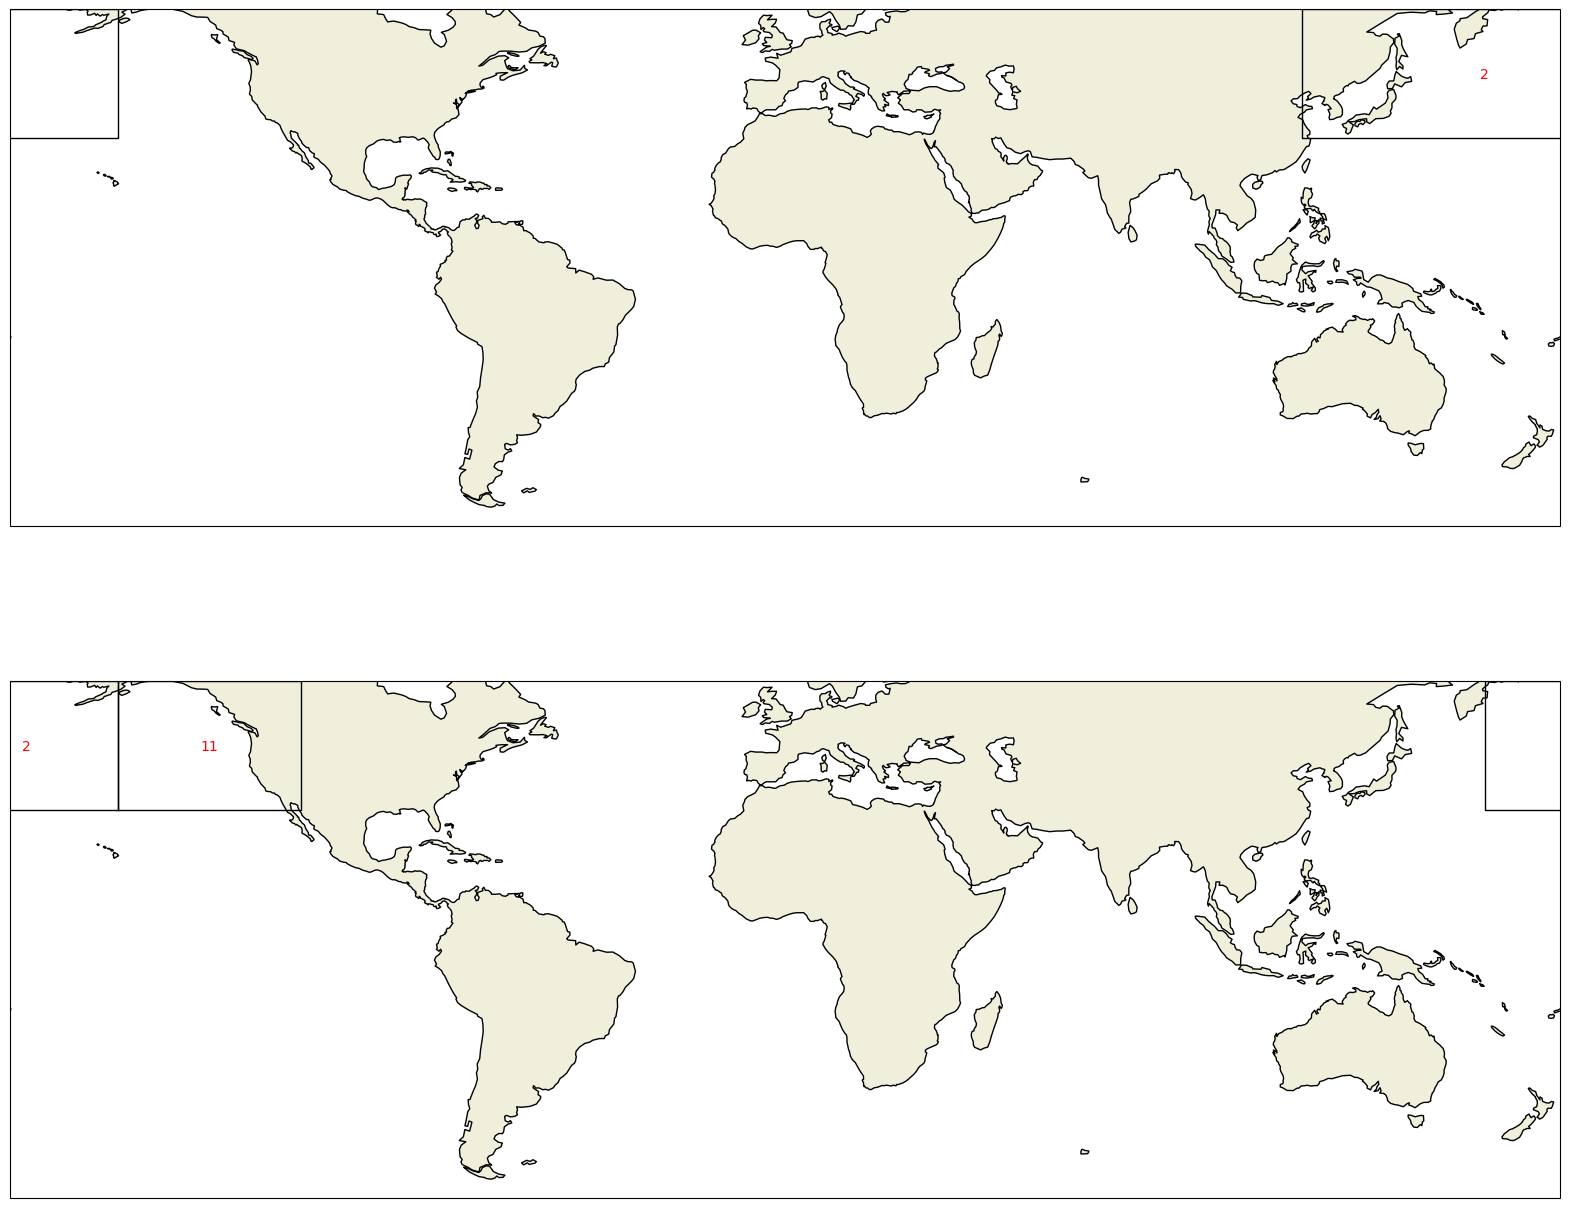

In [16]:
plot_grid_count(df2)

## Chile

In [32]:
region = "chile"
FREQUENCY= "2monthly"
metadata_sst = pd.read_csv(f"data/new_features/{region}/metadata.csv")
metadata_sst["var_temp"] = "sst"
metadata_t2m = pd.read_csv(f"data/new_features_t2m/{region}/metadata.csv")
metadata_t2m["var_temp"] = "t2m"
metadata = pd.concat((metadata_sst,metadata_t2m))
metadata.rename(columns={"id":"id_data"}, inplace=True)
metadata

,id_data,filename,boxes,top_n,var_thresh,modes,frequency,season,methods,var_temp
0,1e8f838e,predictor_1e8f838e.parquet,0,5,NaN,1,yearly,0,ps,sst
1,737da618,predictor_737da618.parquet,0,10,NaN,1,yearly,0,ps,sst
2,87c8b0d7,predictor_87c8b0d7.parquet,0,15,NaN,1,yearly,0,ps,sst
3,627bcbae,predictor_627bcbae.parquet,0,20,NaN,1,yearly,0,ps,sst
4,7e688c19,predictor_7e688c19.parquet,0,30,NaN,1,yearly,0,ps,sst
...,...,...,...,...,...,...,...,...,...,...
775,f579dc90,predictor_f579dc90_8.parquet,0,30,0.15,3,2monthly,8,ps,t2m
776,f579dc90,predictor_f579dc90_9.parquet,0,30,0.15,3,2monthly,9,ps,t2m
777,f579dc90,predictor_f579dc90_10.parquet,0,30,0.15,3,2monthly,10,ps,t2m
778,f579dc90,predictor_f579dc90_11.parquet,0,30,0.15,3,2monthly,11,ps,t2m


In [33]:
results = pd.read_csv(f"data/{region}_results/results.csv")

In [34]:

summary_r2 = summarize_best_results_by_index(results, metadata, metric="r2", top_n=5, stage="prediction")
summary_mape = summarize_best_results_by_index(results, metadata, metric="mape", top_n=5, stage="prediction")
summary_cv_r2 = summarize_best_results_by_index(results, metadata, metric="cv_r2", top_n=5, stage="CV")


Now we repite for each season

In [38]:
cv_r2_seasons = {}
r2_seasons = {}
mape_seasons = {}
for i in range(13):
    results_season = results[results["season"]==i]
    cv_r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="cv_r2",stage="CV" , top_n=2)
    r2_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="r2",stage="prediction", top_n=2)
    mape_seasons[i] = summarize_best_results_by_index(results_season, metadata, metric="mape",stage="prediction", top_n=2)

cv_r2_seasons = pd.concat(list(cv_r2_seasons.values()))
r2_seasons = pd.concat(list(r2_seasons.values()))
mape_seasons = pd.concat(list(mape_seasons.values()))
print()
r2_seasons[["model","season", "index", "best_value", "training_value", "top_n", "var_thresh"]].to_csv("r2_per_season.csv", index=False)
cv_r2_seasons[["model","season", "index", "best_value", "top_n", "var_thresh"]].to_csv("cv_r2_per_season.csv", index=False)

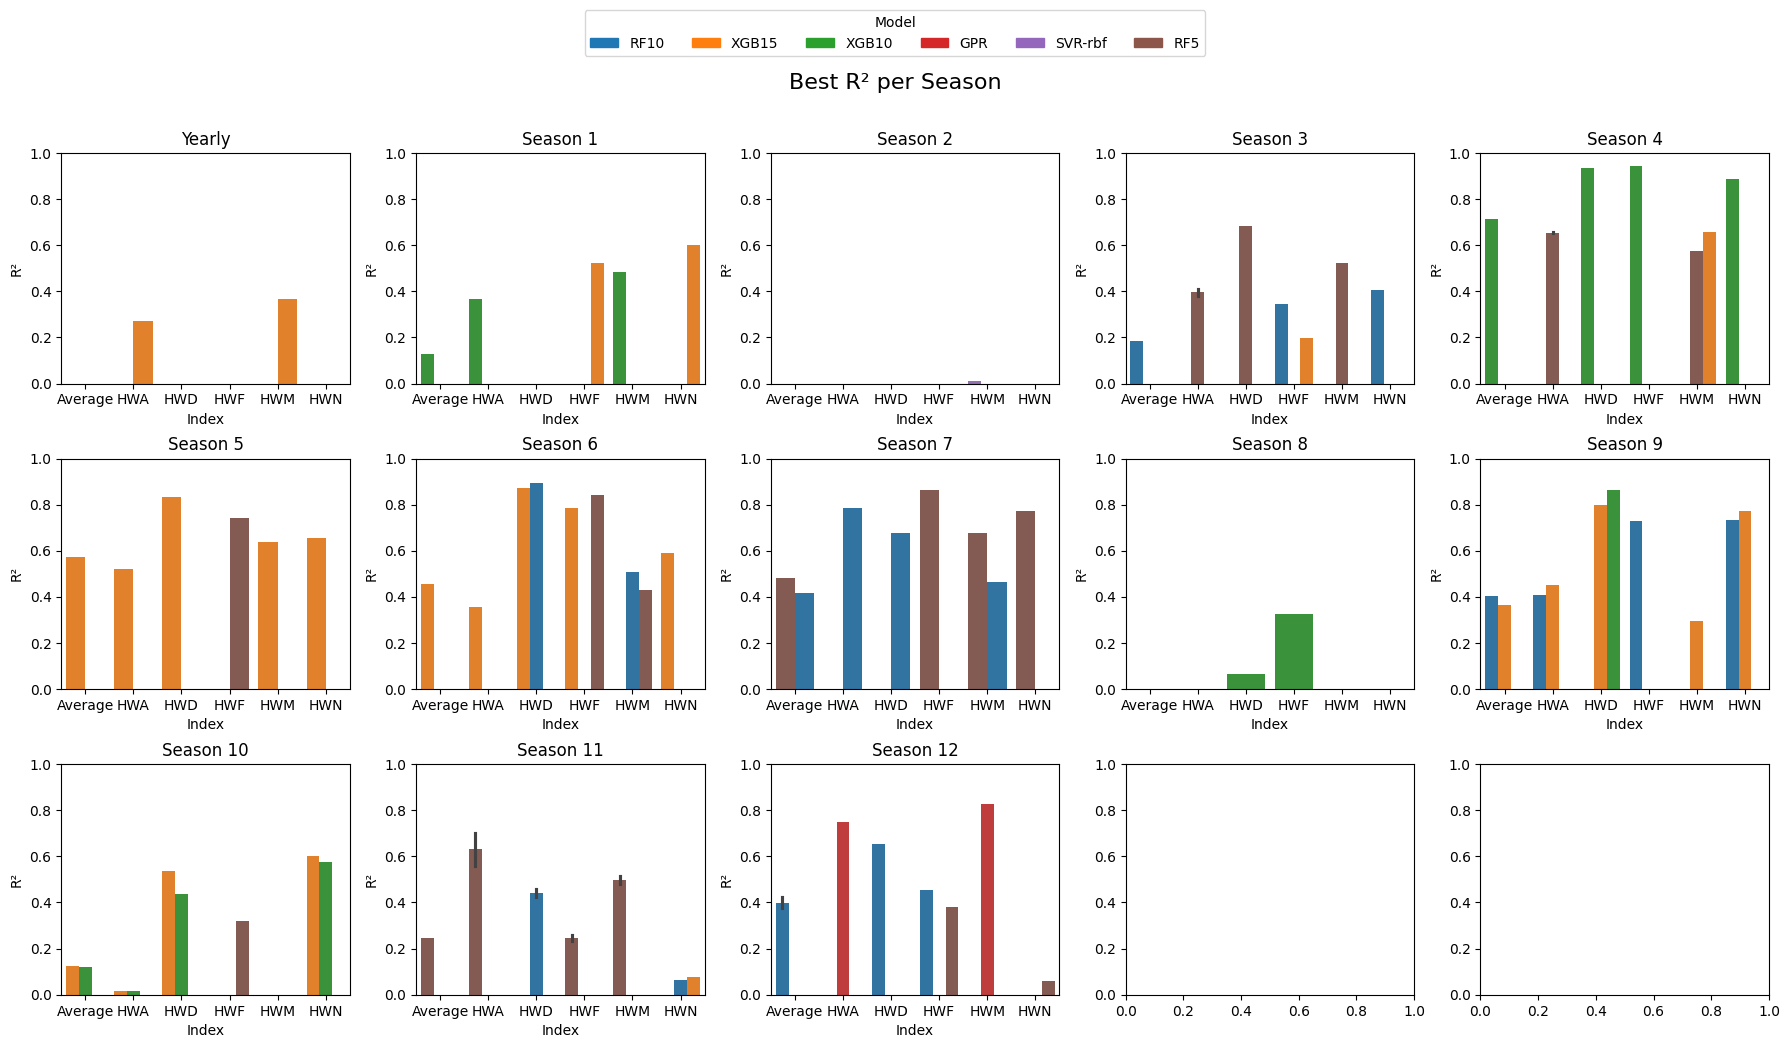

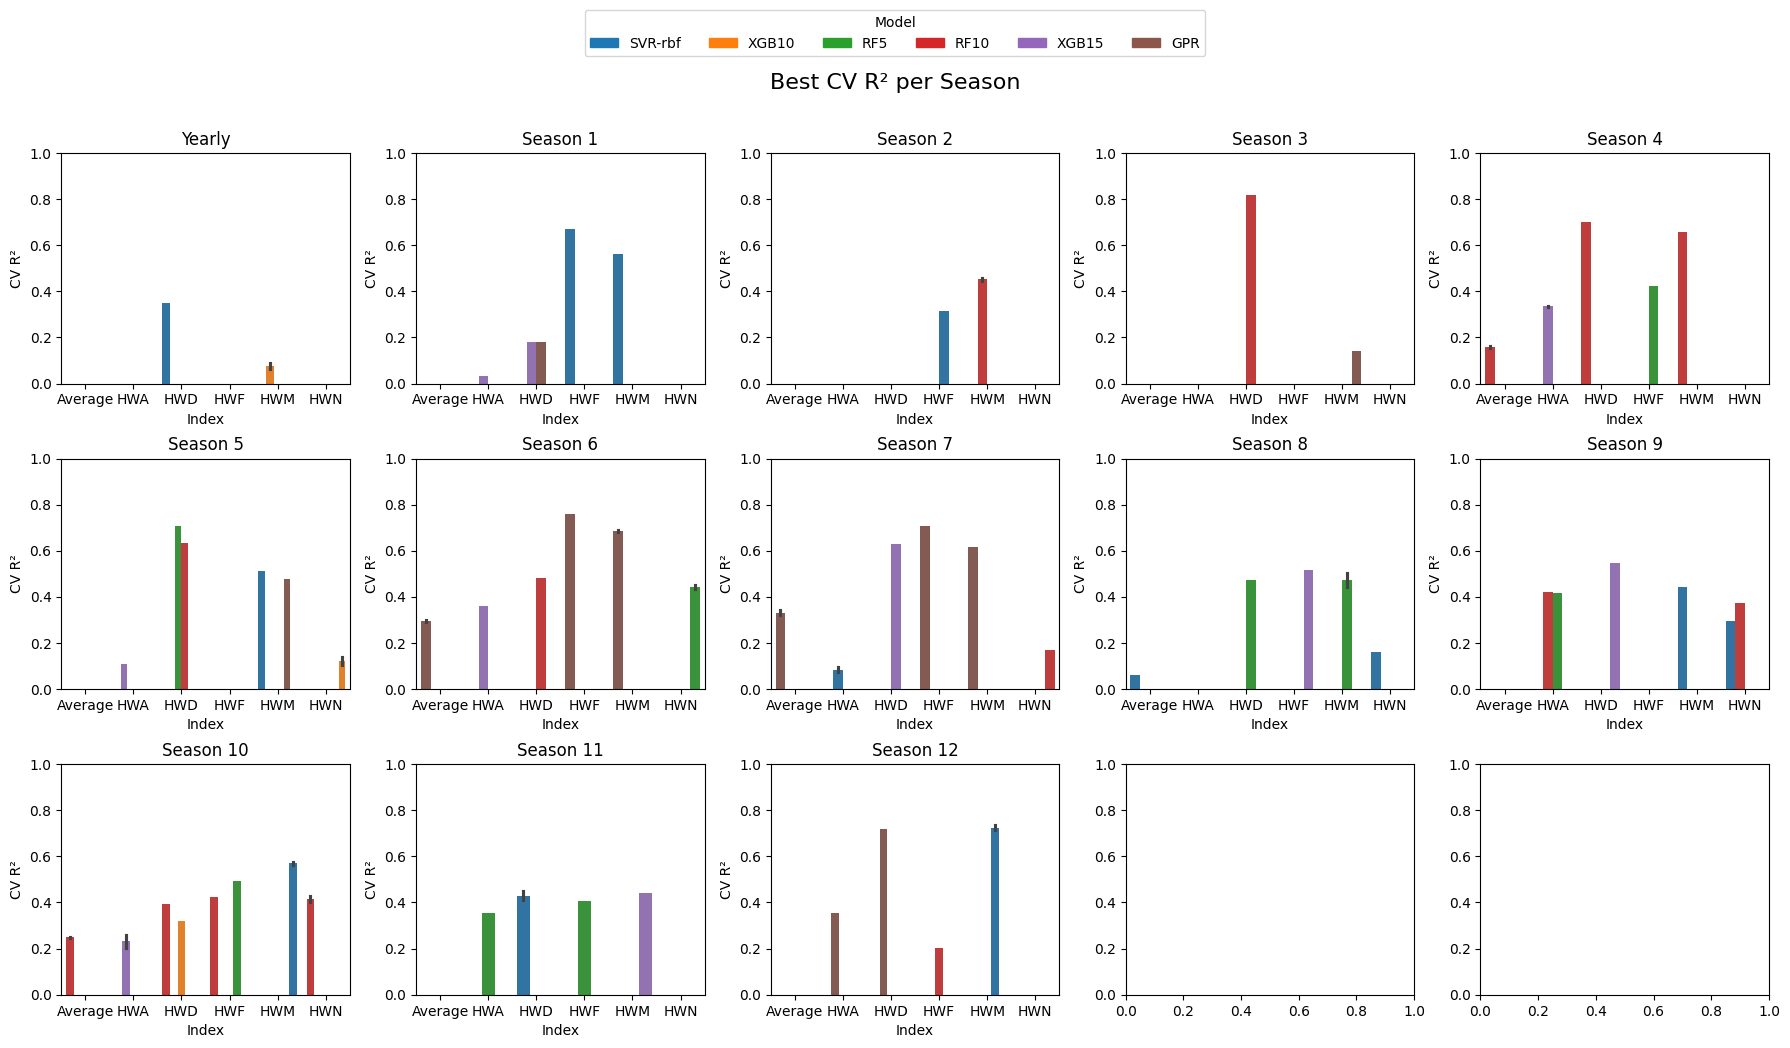

<Figure size 1800x1000 with 0 Axes>

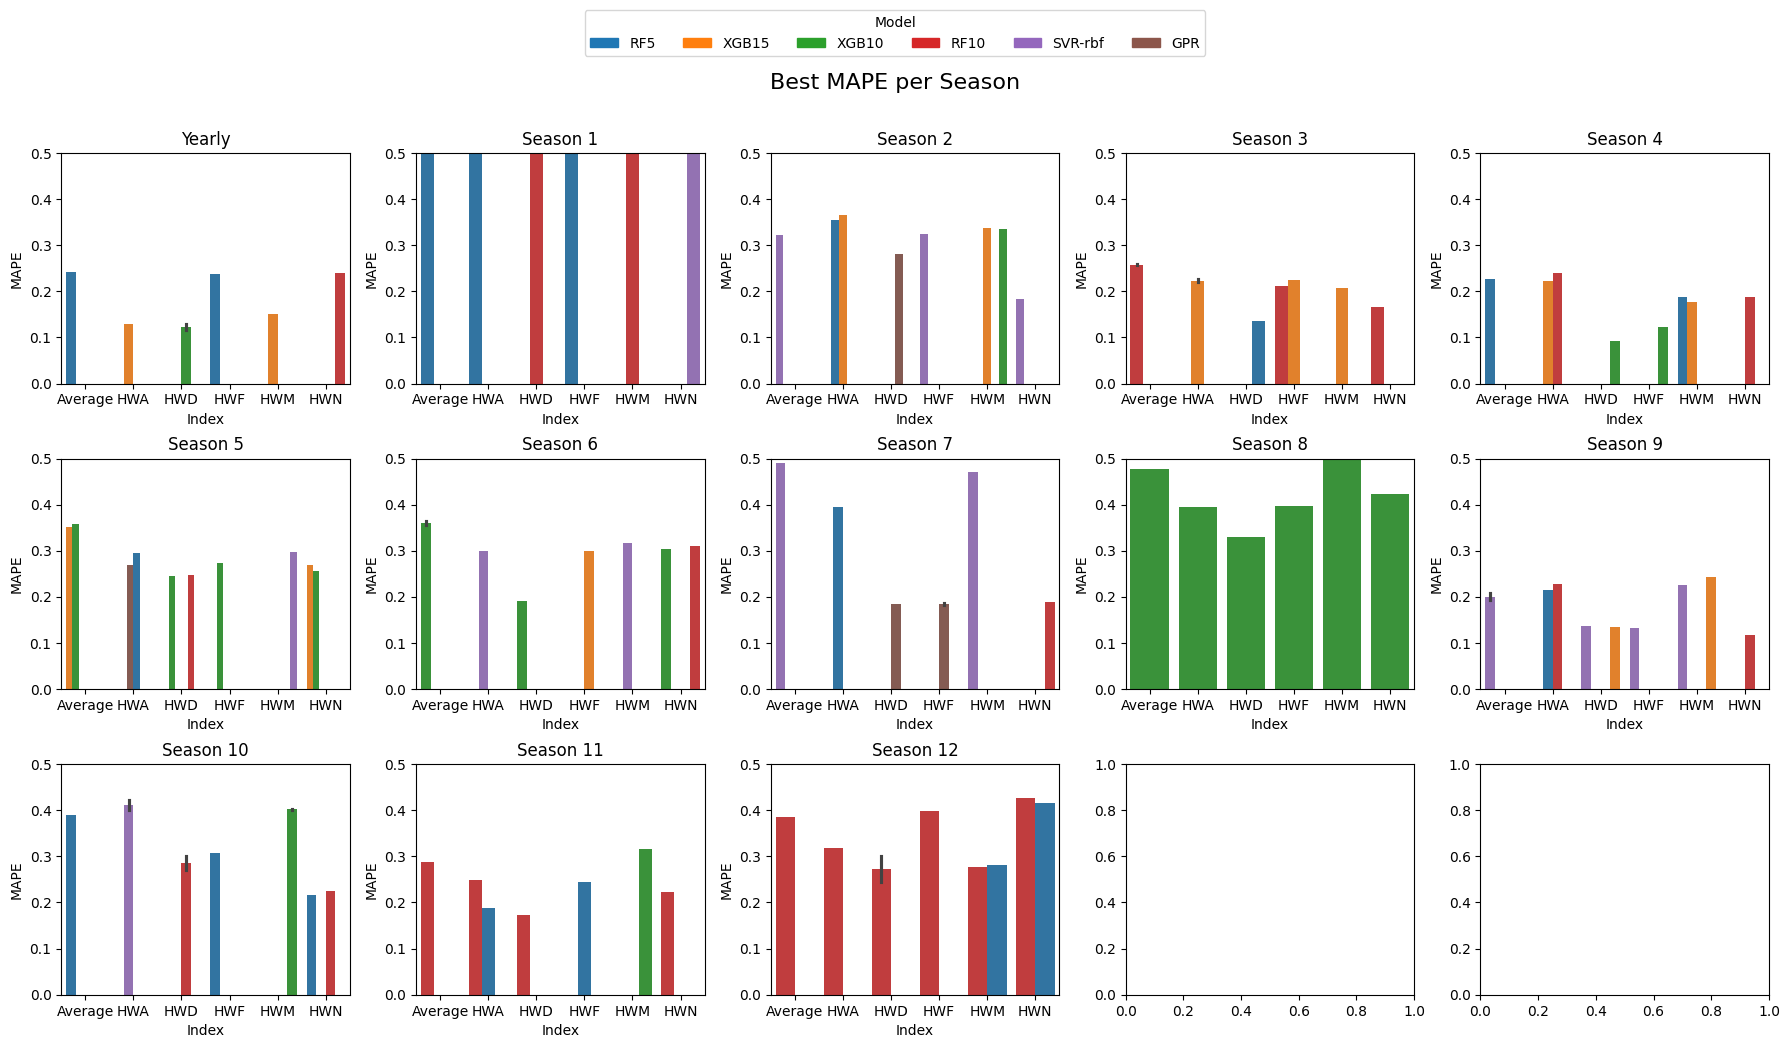

In [36]:
# Plot R2 results
plot_best_results_per_season(r2_seasons, "R²", "Best R² per Season")

# Plot CV R2 results
plot_best_results_per_season(cv_r2_seasons, "CV R²", "Best CV R² per Season")

# Plot MAPE results (invert y-axis since lower is better)
plt.figure(figsize=(18, 10))
plot_best_results_per_season(mape_seasons, "MAPE", "Best MAPE per Season")

C:\Users\marti\AppData\Local\Temp\ipykernel_3436\1172037756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


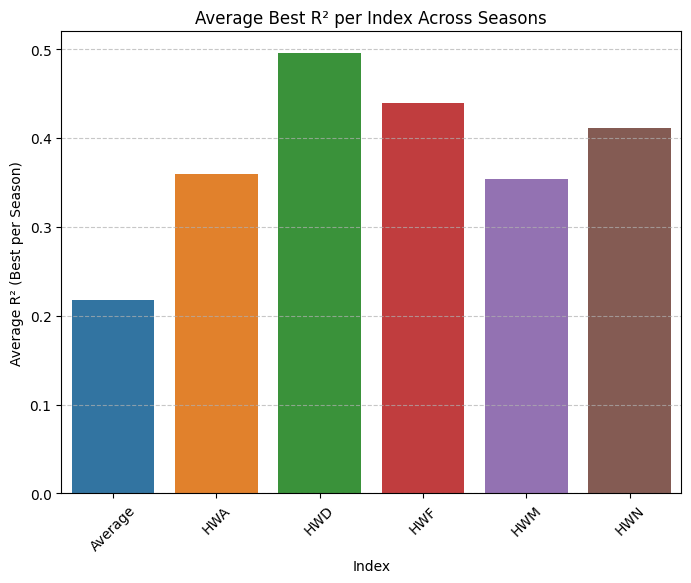

C:\Users\marti\AppData\Local\Temp\ipykernel_3436\1172037756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


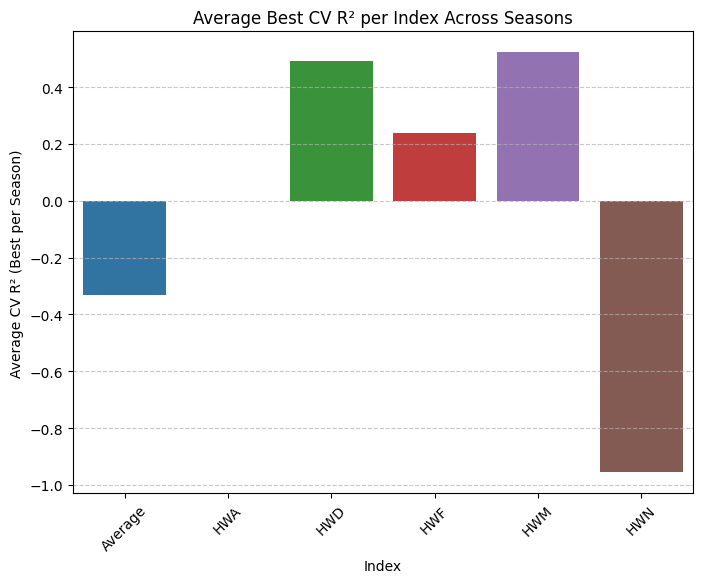

C:\Users\marti\AppData\Local\Temp\ipykernel_3436\1172037756.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_best_results, x="index", y="best_value", palette="tab10")


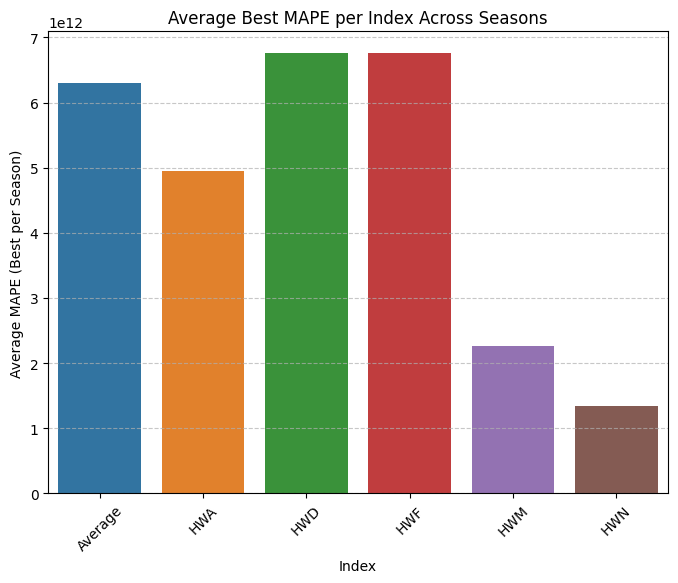

In [39]:
# Example usage
plot_average_best_results(r2_seasons, "R²", "Average Best R² per Index Across Seasons")
plot_average_best_results(cv_r2_seasons, "CV R²", "Average Best CV R² per Index Across Seasons")
plot_average_best_results(mape_seasons, "MAPE", "Average Best MAPE per Index Across Seasons")

In [ ]:
#with open("pcas_1972.pkl", "rb") as inp:
#    pcas_sst = pickle.load(inp)
interest_ids = cv_r2_seasons[(cv_r2_seasons["best_value"] >= 0.7)]
df1 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["var_temp"] == "t2m":
        continue
    else:
        temp = ""
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        pcas = list(data_file.columns[5:])
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_sst[id_pca].variables_dict.values())
            box = pcas_sst[id_pca].box
            mode = pcas[i][-1]
            df1.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_sst
display(df1)



,id_data,id_pca,mode,box,variables
0,61c5eabd,1499,2,"[205, 290, -60, -30]","[SST, U10, V10, Z]"
1,61c5eabd,1489,2,"[205, 290, -60, -30]","[U10, V10, Z]"
2,61c5eabd,1454,2,"[205, 290, -60, -30]",[Z]
3,61c5eabd,1459,2,"[205, 290, -60, -30]","[SST, Z]"
4,61c5eabd,1508,2,"[205, 290, -60, -30]","[SST, SP, U10, V10, Z]"
...,...,...,...,...,...
190,6f63a537,965,2,"[247.5, 290, -60, -30]","[V10, Z]"
191,6f63a537,741,2,"[247.5, 290, -30, 0]","[SST, TTR, U10, Z]"
192,6f63a537,895,2,"[205, 247.5, -60, -30]","[SP, V10]"
193,6f63a537,712,1,"[247.5, 290, -30, 0]","[U10, Z]"


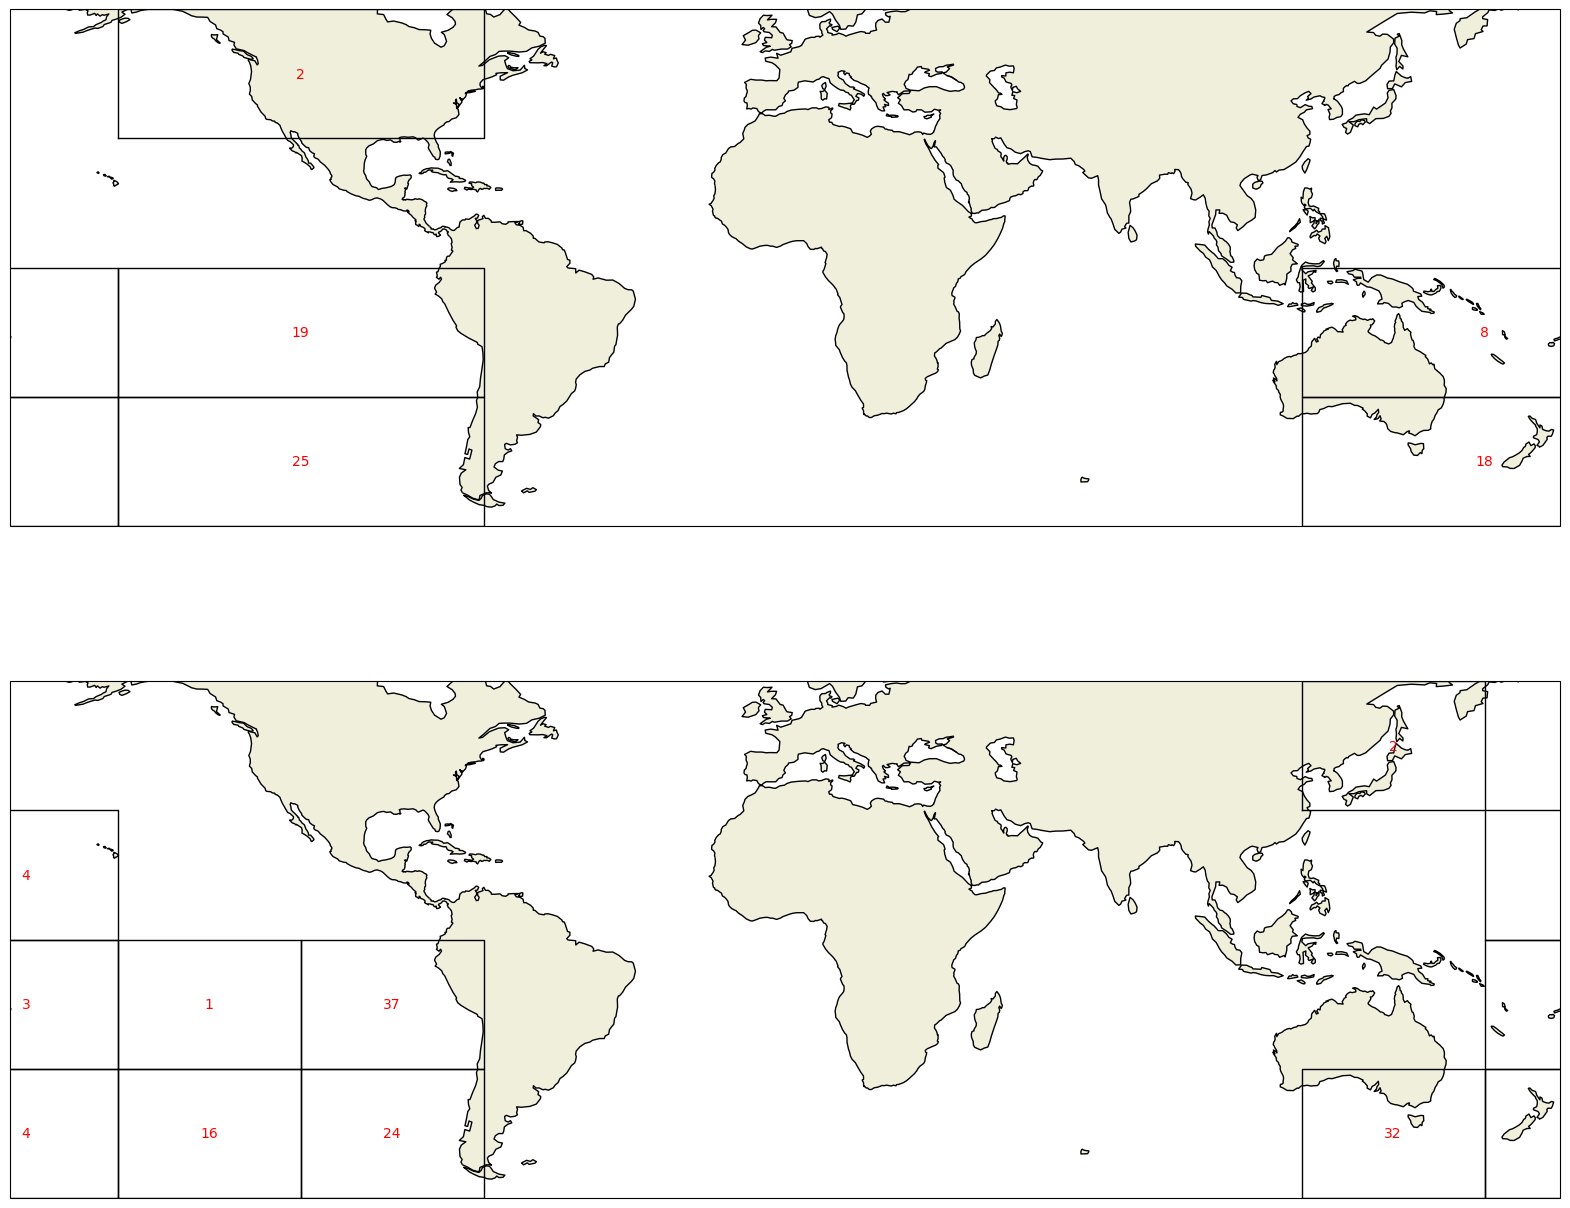

In [33]:
plot_grid_count(df1)

In [34]:
with open("pcas_t2m.pkl", "rb") as inp:
    pcas_t2m = pickle.load(inp)
df2 = pd.DataFrame(columns=["id_data", "id_pca", "mode", "box", "variables"])
k=0
for index, row in interest_ids.iterrows():
    id = row["id_data"]
    season = row["season"]
    if row["var_temp"] == "t2m":
        temp = "_t2m"
        with open("pcas_t2m.pkl", "rb") as inp:
            pcas_t2m = pickle.load(inp)
        data_file = pd.read_parquet(f"data/new_features{temp}/{region}/predictor_{id}_{season}.parquet")
        pcas = list(data_file.columns[5:])
        for i in range(len(pcas)):
            id_pca = int(re.search(r'PC_(.*?)-Mode-', pcas[i]).group(1))
            vars = list(pcas_t2m[id_pca].variables_dict.values())
            box = pcas_t2m[id_pca].box
            mode = pcas[i][-1]
            df2.loc[k] = [id, id_pca, mode, box, vars]
            k+=1
del pcas_t2m
display(df2)

,id_data,id_pca,mode,box,variables
0,76c7ef4c,965,2,"[247.5, 290, -60, -30]","[Z, T2M]"
1,76c7ef4c,885,1,"[205, 247.5, -60, -30]",[V10]
2,76c7ef4c,766,1,"[120, 162.5, -60, -30]","[SP, T2M]"
3,76c7ef4c,780,2,"[120, 162.5, -60, -30]","[SP, TTR, T2M]"
4,76c7ef4c,887,2,"[205, 247.5, -60, -30]",[T2M]
5,6b480627,965,2,"[247.5, 290, -60, -30]","[Z, T2M]"
6,6b480627,885,1,"[205, 247.5, -60, -30]",[V10]
7,6b480627,766,1,"[120, 162.5, -60, -30]","[SP, T2M]"
8,6b480627,780,2,"[120, 162.5, -60, -30]","[SP, TTR, T2M]"
9,6b480627,887,2,"[205, 247.5, -60, -30]",[T2M]


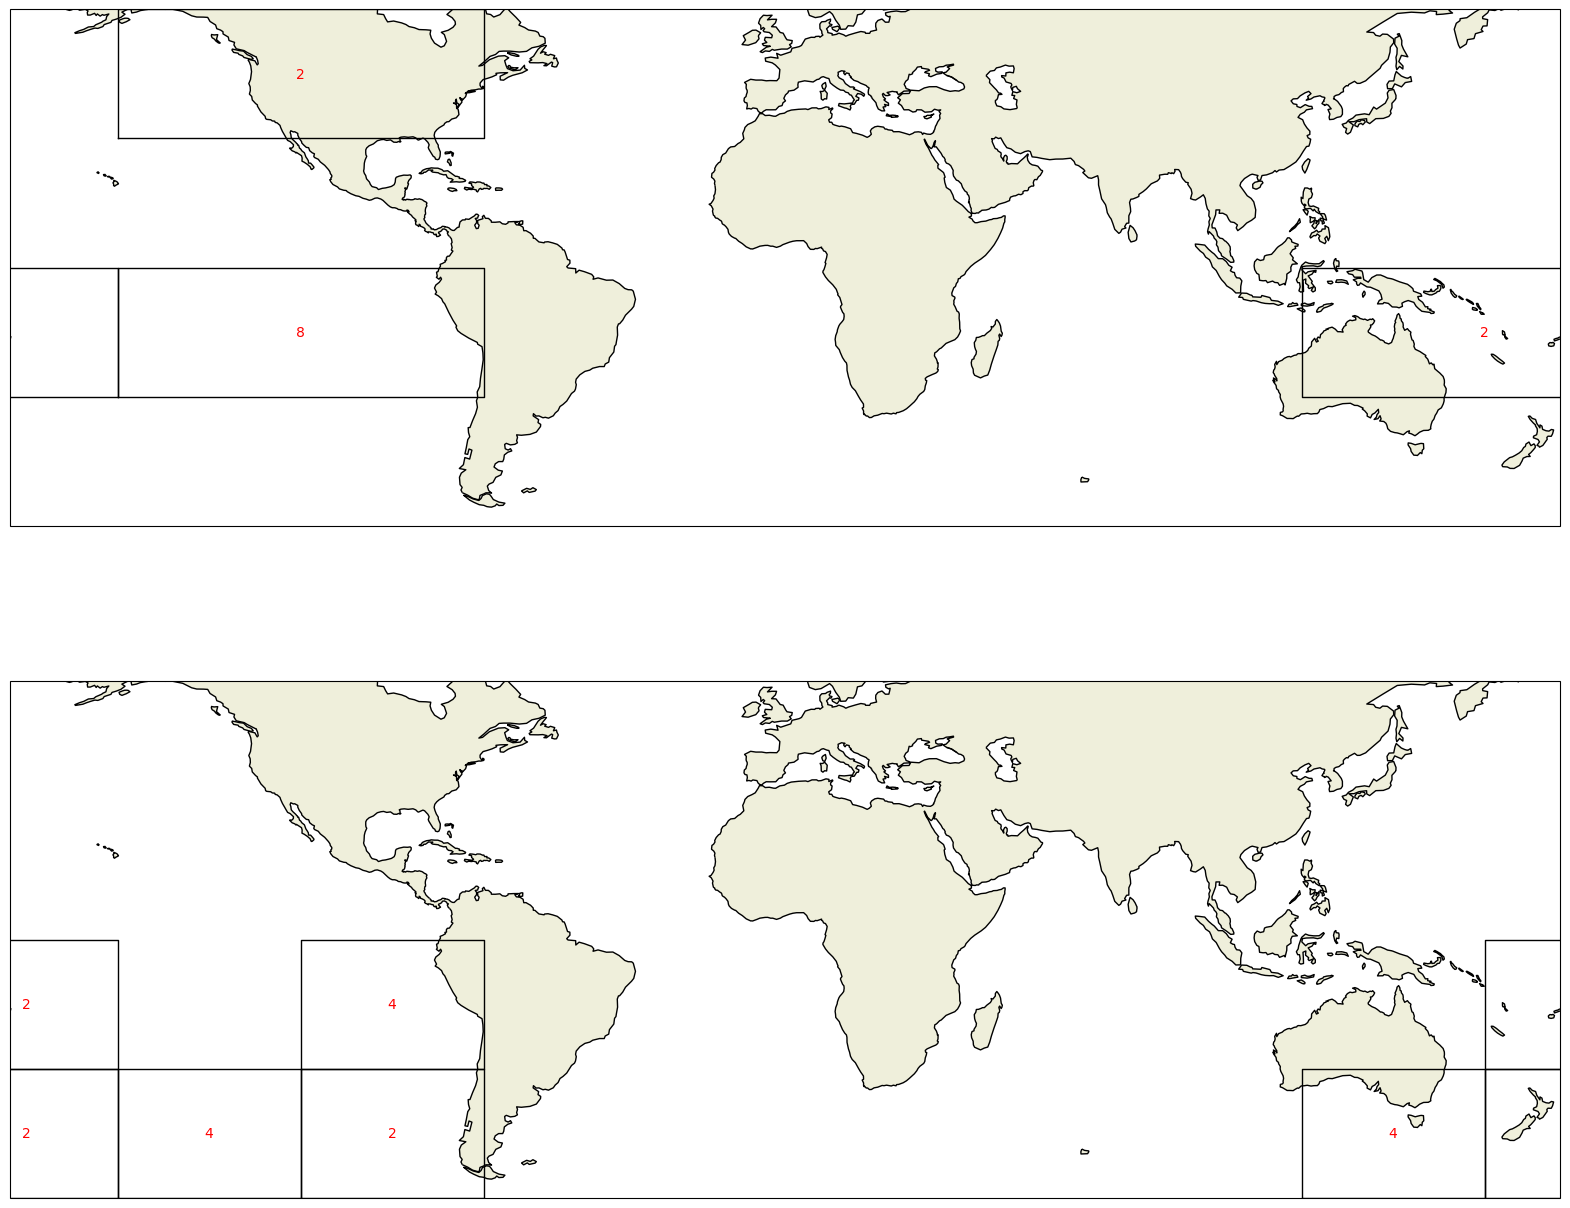

In [35]:
plot_grid_count(df2)